In [1]:
import sys
sys.path.append("..")

In [2]:
import wfdb

from qrsc.utils.annotationutils import trigger_points

def read_record(path, sampto):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    positions, labels = trigger_points(annotation, with_labels=True)
    return record, positions, labels

def read_records(directory, names, sampto):
    records, positions, labels = [], [],  []
    for name in names:
        path = "/".join([directory, name])
        record, pos, labs = read_record(path, sampto)
        records.append(record)
        positions.append(pos)
        labels.append(labs)
    return records, positions, labels

In [3]:
record_dir = "../physionet.org/files/mitdb/1.0.0"
test_path = '/'.join([record_dir, '106'])
train_names = ["100", "101", "102", "103", "104"]
sampto = None

train_records, train_positions, train_labels = read_records(record_dir, train_names, sampto)
test_record, test_positions, test_labels = read_record(test_path, sampto)

In [ ]:
from qrsc.detectors import GarciaBerdonesDetector

rng = range(5, 26, 5)

detectors = [
    GarciaBerdonesDetector(
        name = str(ws),
        batch_size = 32,
        window_size = ws,
        epochs = 3)
    for ws in rng]

for d in detectors:
    d.train(train_records, train_positions)

Using TensorFlow backend.
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/sit

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
101561/101561 [==============================] - 128s 1ms/step - loss: 0.0208
Epoch 2/3
101561/101561 [==============================] - 125s 1ms/step - loss: 0.0168
Epoch 3/3
101561/101561 [==============================] - 128s 1ms/step - loss: 0.0158
Epoch 1/3
 69281/101561 [===================>..........] - ETA: 40s - loss: 0.0245

In [10]:
from qrsc.utils.triggerutils import signal_to_points

trigger_signals = [d.trigger_signal(test_record) for d in detectors]
certainties = [signal_to_points(ts, with_certainty=True)[1] for ts in trigger_signals]

In [11]:
import pandas as pd

df = pd.DataFrame([])

for c, ws in zip(certainties, rng):
    temp_df = pd.DataFrame(c, columns=['Certainty'])
    temp_df['Window Size'] = ws
    df = df.append(temp_df)

In [20]:
from functools import partial
import numpy as np

grouped = df.groupby('Window Size')
medians = grouped.aggregate(np.median)
perc_5 = grouped.aggregate(partial(np.percentile, q=25))
perc_95 = grouped.aggregate(partial(np.percentile, q=75))

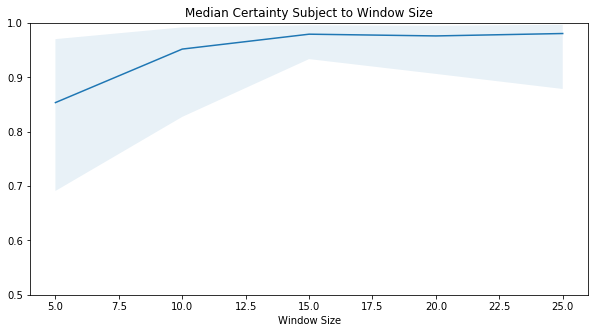

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

ax.plot(medians)
ax.fill_between(perc_5.index, perc_5.Certainty, perc_95.Certainty, alpha=.1)

ax.set_ylim(0.5,1)
ax.set_xlabel("Window Size")
ax.set_title("Median Certainty Subject to Window Size")
fig.suptitle("")

ax

In [24]:
fig.savefig('../generated/figures/impact_window_size.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.1)